**Disclaimer :** \
This is not a working model, but I decided to include it anyway. \
The integer normalization and one-hot encoding were all done successfully without SKLearn. \
I consulted an external source for the multiple regression model, but couldn't get the weight matrix to work properly with the input.\
(This is also why I included this separately from the working model that uses SKLearn)

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

raw_df = pd.read_csv("auto-mpg.csv")
raw_df['horsepower'] = (raw_df['horsepower']).astype(int)
raw_df['origin'] = (raw_df['origin']).astype(str)

raw_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


## Correlation Heatmap

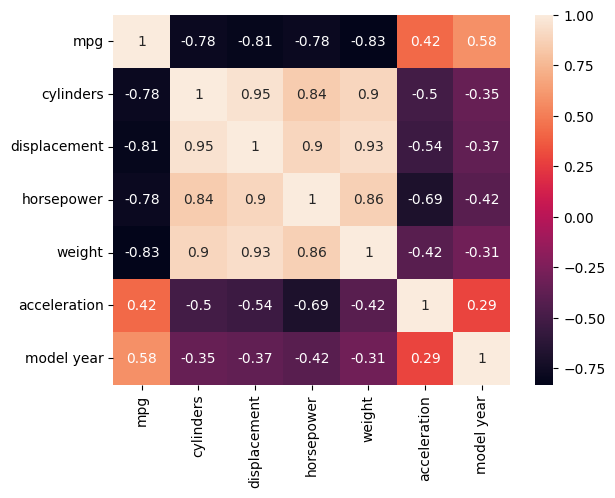

In [8]:
import seaborn as sb

#create correlation heatmap of numerical values in raw_df
dataplot = sb.heatmap(raw_df.corr(numeric_only=True), annot=True)


We see that the factors which show the highest correlation with ```mpg``` are the **number of cylinders, displacement,** **horsepower** and **weight** of the vehicle, with the rest also having a significant, albeit weaker, correlation.

As all variables affect ```mpg``` significantly, we don't need to remove any of them.

## Data Preprocessing

In [9]:
#Function to separate data into train and test datasets

np.random.seed(42)

def train_test_split(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [49]:
#define numerical and categorical columns
num_cols = ["cylinders", "displacement", "horsepower", 
            "weight", "acceleration", "model year"]
cat_cols = ["origin"]
cat_df = raw_df[cat_cols]

# normalize the numerical data
normalized_df = (raw_df[num_cols] - raw_df[num_cols].mean())/raw_df[num_cols].std()

# one-hot encode the categorical data
encoded_df = pd.get_dummies(cat_df, dtype='int')

# combine numerical and categorical columns into the final prepared dataframe 
prepared_df = normalized_df.join([encoded_df, raw_df['mpg']])

# split the prepared data into train and test datasets
train_df, test_df = train_test_split(prepared_df, 0.2)

train_df.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin_1,origin_2,origin_3,mpg
0,1.482053,1.075915,0.663285,0.619748,-1.283618,-1.623241,1,0,0,18.0
255,0.309571,0.359199,-0.375915,0.273623,0.601216,0.548467,1,0,0,19.4
68,1.482053,1.486832,1.442685,1.740536,-0.739916,-1.080314,1,0,0,12.0
382,-0.862911,-0.367073,-0.323955,-0.462189,-0.377448,1.634321,1,0,0,26.0
18,-0.862911,-0.930889,-0.427875,-0.997859,-0.377448,-1.623241,0,0,1,27.0


In [46]:
# The regression model

class regression_model:
    def __init__(self, learning_rate=0.0001, num_weights=2, 
                 bias=0.001*np.random.rand()):
        self.learning_rate = learning_rate
        self.weight = np.random.rand(num_weights)
        self.bias = bias

    def multiple_regression(self, features):
        return (features @ self.weight) + self.bias

    def loss_fn(self, ground_truth, predictions):
        return np.mean(np.square((ground_truth-predictions)))

    def gradient_descent(self, features, ground_truth, predictions):
        error = ground_truth - predictions
        dW = []
        for col in features.columns:
            dW.append(-2*np.mean((error*features[col])))
        db = -2*np.mean(error)
        return dW, db

    def optimize_model_parameters(self, features, ground_truth, predictions):
        dW, db = self.gradient_descent(features, ground_truth, 
                                       predictions)
        self.weight[0] += self.learning_rate * -dW[0]
        self.weight[1] += self.learning_rate * -dW[1]
        self.bias += self.learning_rate * -db

    def fit(self, X, y_true, epochs=10, to_print=False):
        history={'epoch':[],'loss':[]}
        for epoch in range(epochs):
            y_hat = self.multiple_regression(X)
            loss = self.loss_fn(y_true, y_hat)
            self.optimize_model_parameters(X, y_true, y_hat)
            if to_print:
                print('epoch:',epoch,'loss:',loss)
            history['epoch'].append(epoch)
            history['loss'].append(loss)
        return history

    def predict(self, test_features):
        y_hat = self.multiple_regression(test_features)
        return y_hat

    def get_model_coef(self):
        return self.weight, self.bias

    def evaluate(self,test_features,y_test):
        y_hat = self.predict(test_features)
        loss = self.loss_fn(y_test,y_hat)
        return loss

In [50]:
X_train = train_df.iloc[:, 0:9]
y_train = train_df.iloc[:, 9:]

model = regression_model()
# history = model.fit(X_train, y_train, epochs=1000)